# Análise Generalizada de SAM (Spectral Angle Mapper)

Este notebook permite configurar parâmetros operacionais (RPM, Diâmetro de Falha) e realizar automaticamente:
1.  **Busca de Sinais Reais**: Seleção robusta de múltiplos sinais de referência no dataset.
2.  **Geração de Sinais Sintéticos**: Criação de sinais via métodos FFT e Impulso para as condições especificadas.
3.  **Comparação Quantitativa**: Cálculo da métrica SAM par-a-par e estatística (Média/Desvio).

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.spatial.distance import cosine
import random

# Adicionar src ao path para importar módulos do projeto
sys.path.append(os.path.abspath('src'))

import segment_and_split_data as ssd
import generate_synthetic_data as gsd
# generate_impulse_data não é usado diretamente pois definimos localmente
import bearing_utils as bu

Iniciando a leitura e segmentação dos arquivos em 'c:\Users\Cliente\Documents\GitHub\TCC\data'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 3184

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE (chave: '1730

## 1. Configuração de Parâmetros
Defina aqui as condições operacionais para a análise.

In [2]:
# --- Parâmetros de Entrada ---
TARGET_RPM = 1750          # Rotação do eixo (Ex: 1730, 1750, 1772, 1797)
TARGET_DIAMETER_MM = 0.5   # Diâmetro da falha alvo em mm (aprox 0.021")
NUM_SAMPLES = 20            # Número de amostras reais para usar na média do SAM

# --- Constantes do Sistema ---
FS = 12000                 # Frequência de Amostragem (Hz)
N_POINTS = 4096            # Tamanho do segmento

In [18]:
# --- Configuração de Sweep de Parâmetros ---

# RPMs disponíveis no dataset CWRU
RPMS = [1730, 1750, 1772, 1797]

# Diâmetros de falha em mm (aproximadamente 0.007", 0.014", 0.021", 0.028")
DIAMETERS_MM = [0.1778, 0.3556, 0.5334, 0.7112]

# Labels convenientes para visualização
CWru_DIA_MAP = {
    0.1778: '0.007"',
    0.3556: '0.014"',
    0.5334: '0.021"',
    0.7112: '0.028"'
}

# Grade de K por tipo de falha (valores centrados nos usados na Seção 3)
K_GRID = {
    'OR': [0.02, 0.05, 0.1],   # Outer race (Pista Externa)
    'IR': [0.5, 0.8, 1],      # Inner race (Pista Interna)
    'B':  [0.02, 0.05, 0.08]       # Ball (Esfera)
}


## 2. Funções Auxiliares
Funções para cálculo do SAM, espectro e filtragem de dados.

In [19]:
def calcular_sam_graus(fft_ref, fft_alvo):
    """Calcula o ângulo SAM (graus) entre dois espectros de magnitude."""
    if np.iscomplexobj(fft_ref): fft_ref = np.abs(fft_ref)
    if np.iscomplexobj(fft_alvo): fft_alvo = np.abs(fft_alvo)
    
    min_len = min(len(fft_ref), len(fft_alvo))
    dist = cosine(fft_ref[:min_len], fft_alvo[:min_len])
    sim = np.clip(1.0 - dist, -1.0, 1.0)
    return np.degrees(np.arccos(sim))

def get_mag_spectrum(sig):
    """Calcula o espectro unilateral de magnitude normalizado."""
    yf = fft(sig)
    return 2.0/len(sig) * np.abs(yf[0:len(sig)//2])

def criar_resposta_impulso(taxa_amostral, tipo_falha, damping, duracao_pulso, num_modos=6):
    """Cria resposta ao impulso somando modos vibracionais naturais (Bearing Utils)."""
    # Obter frequências naturais
    df_nat = bu.get_bearing_natural_frequencies()
    
    if tipo_falha == 'Pista Externa':
        df_race = df_nat[df_nat['Race'] == 'Outer']
    else: 
        df_race = df_nat[df_nat['Race'] == 'Inner']
    
    modos = df_race.head(num_modos)
    
    n_pontos = int(duracao_pulso * taxa_amostral)
    t_pulse = np.linspace(0, duracao_pulso, n_pontos, endpoint=False)
    pulso_total = np.zeros(n_pontos)
    
    for _, modo in modos.iterrows():
        fn = modo['Freq_Hz']
        mass = modo['Mass_kg']
        wn = 2 * np.pi * fn
        
        if wn > 0:
            recept = 1.0 / (mass * wn**2)
            A = damping * wn
            wd = wn * np.sqrt(1 - damping**2)
            
            pulso_modo = recept * np.exp(-A * t_pulse) * np.sin(wd * t_pulse)
            pulso_total += pulso_modo
            
    return pulso_total

def gerar_sinal_impulso_completo(fs, duration_points, defect_freq_hz, tipo_falha_str):
    """Gera o sinal completo via convolução do trem de impulsos com a resposta."""
    duration_sec = duration_points / fs
    t_total = np.linspace(0, duration_sec, duration_points, endpoint=False)
    
    # 1. Trem de Impulsos
    trem = np.zeros(duration_points)
    periodo_s = 1.0 / defect_freq_hz
    ts = 1.0 / fs
    
    for t_imp in np.arange(0, duration_sec, periodo_s):
        idx = int(t_imp / ts)
        if idx < duration_points:
            trem[idx] = 1.0
            
    # 2. Resposta ao Impulso
    resp_imp = criar_resposta_impulso(
        taxa_amostral=fs,
        tipo_falha=tipo_falha_str,
        damping=0.1,
        duracao_pulso=0.02,
        num_modos=6
    )
    if np.max(np.abs(resp_imp)) > 0:
        resp_imp /= np.max(np.abs(resp_imp))
        
    # 3. Convolução
    sinal_conv = np.convolve(trem, resp_imp, mode='same')
    return sinal_conv

def get_real_signals_metadata_batch(rpm, type_code, target_dia_mm, num_samples):
    cwru_map = {0.1778: '0.007"', 0.3556: '0.014"', 0.5334: '0.021"', 0.7112: '0.028"'}
    closest_mm = min(cwru_map.keys(), key=lambda k: abs(k - target_dia_mm))
    target_dia_str = cwru_map[closest_mm]
    type_map = {'OR': 'Pista Externa', 'IR': 'Pista Interna', 'B': 'Esfera', 'Normal': 'Normal'}
    target_type = type_map.get(type_code, type_code)
    
    candidates = []
    for chave, df in ssd.dicionario_teste.items():
        if df.empty: continue
        try:
            row_rpm = int(df['rotacao_rpm'].iloc[0])
            row_type = str(df['tipo_falha'].iloc[0])
            row_dia = str(df['diametro_falha'].iloc[0]).replace('"', '').strip()
            target_dia_clean = target_dia_str.replace('"', '').strip()
            
            if abs(row_rpm - rpm) < 50:
                if row_type == target_type:
                    if target_type == 'Normal' or row_dia == target_dia_clean:
                        candidates.append((chave, df['amplitude'].values))
        except: continue
    if len(candidates) > num_samples:
        selected = random.sample(candidates, num_samples)
    else:
        selected = candidates
    return selected

def get_normal_signal(rpm):
    normals = get_real_signals_metadata_batch(rpm, 'Normal', 0, 1)
    if normals:
        return normals[0][1]
    return np.random.normal(0, 0.01, N_POINTS)

## 3. Execução da Análise
Geração e Comparação para todas as falhas.

In [20]:
# 3. Execução da Análise em Sweep (RPM × Diâmetro × K)

results = []

falhas = [
    ('Pista Externa', 'OR', 'outer'),
    ('Pista Interna', 'IR', 'inner'),
    ('Esfera',       'B',  'ball')
]

print("Iniciando sweep de parâmetros para SAM...\n")

for rpm in RPMS:
    # Ruído de fundo (Normal) para este RPM
    sinal_normal = get_normal_signal(rpm)
    if len(sinal_normal) > N_POINTS:
        sinal_normal = sinal_normal[:N_POINTS]
    elif len(sinal_normal) < N_POINTS:
        sinal_normal = np.pad(sinal_normal, (0, N_POINTS - len(sinal_normal)))

    for diam_mm in DIAMETERS_MM:
        for nome, type_code, gen_type in falhas:
            # Grade de K dependente do tipo de falha
            for k_val in K_GRID[type_code]:
                # 1. Obter Sinais Reais de Referência
                refs = get_real_signals_metadata_batch(rpm, type_code, diam_mm, NUM_SAMPLES)
                num_refs = len(refs)

                # 2. Calcular Frequência de Falha (para Impulso)
                tandon_coeffs = bu.calculate_tandon_coefficients(diam_mm, rpm, gen_type)
                char_freq = tandon_coeffs['frequencies']['defect_freq_hz']

                # --- Método A: FFT Model ---
                try:
                    spec_df = None
                    if type_code == 'OR':
                        spec_df = bu.calcular_espectro_outer_race(diam_mm, rpm, K=k_val)
                    elif type_code == 'IR':
                        spec_df = bu.calcular_espectro_inner_completo(diam_mm, rpm, K=k_val)
                    elif type_code == 'B':
                        spec_df = bu.calcular_espectro_ball_completo(diam_mm, rpm, K=k_val)

                    if spec_df is not None and not spec_df.empty:
                        sig_fft_pure = gsd.synthesize_time_signal(spec_df, duration=N_POINTS/FS, fs=FS)
                        if len(sig_fft_pure) > N_POINTS:
                            sig_fft_pure = sig_fft_pure[:N_POINTS]
                        elif len(sig_fft_pure) < N_POINTS:
                            sig_fft_pure = np.pad(sig_fft_pure, (0, N_POINTS - len(sig_fft_pure)))
                        sig_fft_final = sinal_normal + sig_fft_pure
                    else:
                        sig_fft_final = np.zeros(N_POINTS)
                except Exception as e:
                    print(f"[Erro FFT Gen] RPM={rpm}, dia={diam_mm}, tipo={type_code}, K={k_val}: {e}")
                    sig_fft_final = np.zeros(N_POINTS)

                # --- Método B: Impulse Model ---
                try:
                    sig_imp_pure = gerar_sinal_impulso_completo(
                        fs=FS,
                        duration_points=N_POINTS,
                        defect_freq_hz=char_freq,
                        tipo_falha_str=nome
                    )
                    # Escala pela mesma K para tornar comparável
                    sig_imp_final = sinal_normal + (k_val * sig_imp_pure)
                except Exception as e:
                    print(f"[Erro Impulso] RPM={rpm}, dia={diam_mm}, tipo={type_code}, K={k_val}: {e}")
                    sig_imp_final = np.zeros(N_POINTS)

                # 3. Calcular SAM e registrar resultados
                sam_fft_vals = []
                sam_imp_vals = []

                spec_syn_fft = get_mag_spectrum(sig_fft_final)
                spec_syn_imp = get_mag_spectrum(sig_imp_final)

                for _, sig_real in refs:
                    spec_real = get_mag_spectrum(sig_real)
                    sam_fft_vals.append(calcular_sam_graus(spec_real, spec_syn_fft))
                    sam_imp_vals.append(calcular_sam_graus(spec_real, spec_syn_imp))

                # Se não houver referências, usar NaN
                if sam_fft_vals:
                    mean_fft = float(np.mean(sam_fft_vals))
                    std_fft = float(np.std(sam_fft_vals))
                else:
                    mean_fft, std_fft = np.nan, np.nan

                if sam_imp_vals:
                    mean_imp = float(np.mean(sam_imp_vals))
                    std_imp = float(np.std(sam_imp_vals))
                else:
                    mean_imp, std_imp = np.nan, np.nan

                dia_label = CWru_DIA_MAP.get(min(CWru_DIA_MAP.keys(), key=lambda k: abs(k - diam_mm)), f"{diam_mm:.4f}m")

                results.append({
                    'rpm': rpm,
                    'diameter_mm': diam_mm,
                    'diameter_label': dia_label,
                    'fault_name': nome,
                    'fault_code': type_code,
                    'method': 'fft',
                    'k': k_val,
                    'num_refs': num_refs,
                    'sam_mean_deg': mean_fft,
                    'sam_std_deg': std_fft
                })

                results.append({
                    'rpm': rpm,
                    'diameter_mm': diam_mm,
                    'diameter_label': dia_label,
                    'fault_name': nome,
                    'fault_code': type_code,
                    'method': 'impulse',
                    'k': k_val,
                    'num_refs': num_refs,
                    'sam_mean_deg': mean_imp,
                    'sam_std_deg': std_imp
                })

# Consolidar em DataFrame
results_df = pd.DataFrame(results)
print("Sweep concluído. Total de linhas em results_df:", len(results_df))
results_df.head()

Iniciando sweep de parâmetros para SAM...

Sweep concluído. Total de linhas em results_df: 288


,rpm,diameter_mm,diameter_label,fault_name,fault_code,method,k,num_refs,sam_mean_deg,sam_std_deg
0,1730,0.1778,"0.007""",Pista Externa,OR,fft,0.02,20,82.746908,3.417684
1,1730,0.1778,"0.007""",Pista Externa,OR,impulse,0.02,20,82.806603,3.399081
2,1730,0.1778,"0.007""",Pista Externa,OR,fft,0.05,20,83.404368,3.262094
3,1730,0.1778,"0.007""",Pista Externa,OR,impulse,0.05,20,82.172873,3.573273
4,1730,0.1778,"0.007""",Pista Externa,OR,fft,0.10,20,84.884430,2.373909


## 4. Visualização Agregada dos Resultados

A partir de `results_df`, podemos criar visualizações agregadas para entender o efeito de RPM, diâmetro, K e tipo de falha sobre o SAM médio.


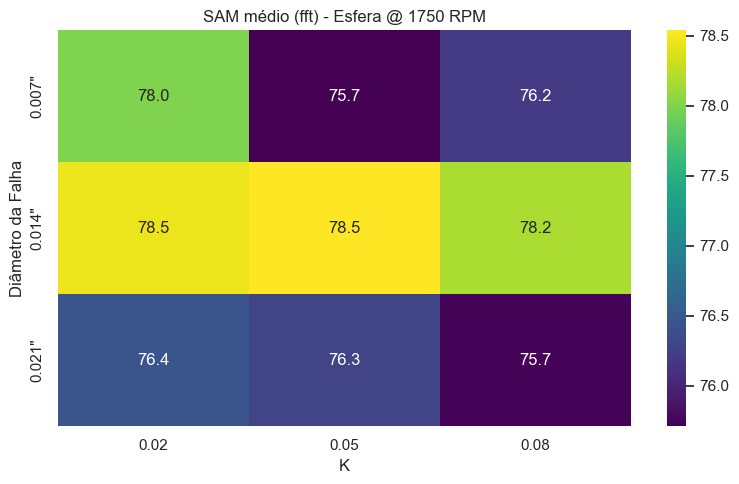

Top 10 combinações (maior SAM médio):


,rpm,fault_name,method,diameter_label,k,num_refs,sam_mean_deg,sam_std_deg
184,1772,Pista Externa,fft,"0.021""",0.10,20,85.626256,1.352196
256,1797,Pista Externa,fft,"0.021""",0.10,20,85.571278,1.231571
40,1730,Pista Externa,fft,"0.021""",0.10,20,85.382479,0.793850
148,1772,Pista Externa,fft,"0.007""",0.10,20,85.237797,2.685451
166,1772,Pista Externa,fft,"0.014""",0.10,20,85.084860,1.847348
4,1730,Pista Externa,fft,"0.007""",0.10,20,84.884430,2.373909
182,1772,Pista Externa,fft,"0.021""",0.05,20,84.725405,1.224336
76,1750,Pista Externa,fft,"0.007""",0.10,20,84.711686,2.581789
220,1797,Pista Externa,fft,"0.007""",0.10,20,84.632109,2.513516
38,1730,Pista Externa,fft,"0.021""",0.05,20,84.608131,0.836607


In [21]:
import seaborn as sns

# Garantir estilo
sns.set(style="whitegrid")

# Exemplo: heatmap para um RPM específico e um tipo de falha
rpm_plot = 1750
fault_plot = 'Esfera'
method_plot = 'fft'  # ou 'impulse'

subset = results_df[(results_df['rpm'] == rpm_plot) &
                    (results_df['fault_name'] == fault_plot) &
                    (results_df['method'] == method_plot)]

if subset.empty:
    print(f"Nenhum dado em results_df para RPM={rpm_plot}, falha='{fault_plot}', método='{method_plot}'.")
else:
    pivot = subset.pivot_table(index='diameter_label', columns='k', values='sam_mean_deg', aggfunc='mean')
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='viridis')
    plt.title(f'SAM médio ({method_plot}) - {fault_plot} @ {rpm_plot} RPM')
    plt.xlabel('K')
    plt.ylabel('Diâmetro da Falha')
    plt.tight_layout()
    plt.show()

# Tabela: top 10 combinações mais similares (menor SAM) para cada método
rank_df = (results_df
           .dropna(subset=['sam_mean_deg'])
           .sort_values('sam_mean_deg', ascending=False)
           .head(10))

print("Top 10 combinações (maior SAM médio):")
rank_df[['rpm', 'fault_name', 'method', 'diameter_label', 'k', 'num_refs', 'sam_mean_deg', 'sam_std_deg']]
